In [6]:
import matplotlib
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix
import warnings #to remove the warnings
import random
warnings.filterwarnings('ignore')

np.random.seed(100)
random.seed(100)
def generateNewFeatureValMultiple(df, col, numberOfBins, numPatients):
    hist, bins = np.histogram(df[col], bins=numberOfBins)
    bin_midpoints = bins[:-1] + np.diff(bins)/2
    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]
    values = np.random.rand(numPatients)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = bin_midpoints[value_bins]
    return list(random_from_cdf)   


In [7]:
raw_df = pd.read_csv('../../Wisconsin_Database/breast-cancer-wisconsin.data', header=None)
cols = ['ID', 'Thickness', 'SizeUniformity', 'ShapeUniformity', 'Adhesion', 'Size', 'BareNuclei', 'Bland Chromatin', 'Nucleoli', 'Mitoses', 'Diagnosis']
raw_df.columns = cols
raw_df['Diagnosis'] = raw_df['Diagnosis'].map(
                   {2:0,4:1})

temp = []
for index, row in raw_df.iterrows():
    if '?' not in row.values:
        temp.append(row)
        
df = pd.DataFrame(np.array(temp), columns=cols)
df['BareNuclei'] = df['BareNuclei'].astype(np.int)
print(df.shape)
print(df)


(683, 11)
          ID Thickness SizeUniformity ShapeUniformity Adhesion Size  \
0    1000025         5              1               1        1    2   
1    1002945         5              4               4        5    7   
2    1015425         3              1               1        1    2   
3    1016277         6              8               8        1    3   
4    1017023         4              1               1        3    2   
..       ...       ...            ...             ...      ...  ...   
678   776715         3              1               1        1    3   
679   841769         2              1               1        1    2   
680   888820         5             10              10        3    7   
681   897471         4              8               6        4    3   
682   897471         4              8               8        5    4   

     BareNuclei Bland Chromatin Nucleoli Mitoses Diagnosis  
0             1               3        1       1         0  
1            10

In [8]:
underknnScores = []
undernaiveBaysScores = []
underlogisticRegressionScores = []
undersvmRegressionScores = []
underdecisionTreeRegressionScores = []
for i in range(10):
    X = df[cols[1:-1]]
    y = df[cols[-1]]
    y=y.astype('int')

    SEED = 42 + i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
    scaler = StandardScaler()
    scaler.fit(X_train)

    col_names=df.columns[2:]
    scaled_df = pd.DataFrame(X_train, columns=col_names)
    scaled_df.describe().T




    trainingSet = X_train.copy()
    trainingSet['Diagnosis'] = y_train
    arr2D = trainingSet.to_numpy()
    columnIndex = -1
    sortedArr = arr2D[arr2D[:,columnIndex].argsort()]
    numZeros = list(sortedArr[:, columnIndex]).count(0)
    benignDF = pd.DataFrame(sortedArr[0:numZeros])
    malignantDF =  pd.DataFrame(sortedArr[numZeros:numZeros+5])
    result = pd.concat([benignDF, malignantDF])
    result.columns = benignDF.columns
    print(benignDF.shape)
    print(malignantDF.shape)
    print(result.shape)
    for j in result:
        result[j] = result[j].astype(np.int)
    X_train = result[result.columns[:-1]]
    y_train = result[result.columns[-1]]

    ''' KNN '''
    
    error = []
    score_vals = []
    for j in range(1, 20):
        knn = KNeighborsRegressor(n_neighbors=j)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_test)
        mae = mean_absolute_error(y_test, pred_i)
        error.append(mae)
        score_vals.append(knn.score(X_test, y_test))
        y_pred = knn.predict(X_test)
        y_pred = y_pred == 1
        performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    bestIndex = score_vals.index(max(score_vals)) + 1  #Adds one because it starts with 1 neighbor not 0

    regressor = KNeighborsRegressor(n_neighbors=bestIndex)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    y_pred = y_pred == 1
    #print('Iteration {}: '.format(i))
    performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    underknnScores.append(performanceAccuracy)

    '''Naive Bayes'''
    nb = GaussianNB()
    nb.fit(X_train, y_train)
    y_pred = (nb.predict(X_test))
    performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    undernaiveBaysScores.append(performanceAccuracy)

    '''Logistic Regression'''

    modelLogistic = LogisticRegression()
    modelLogistic.fit(X_train,y_train)
    y_pred = modelLogistic.predict(X_test)
    performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    underlogisticRegressionScores.append(performanceAccuracy)

    '''SVM'''

    svclassifier = SVC(kernel='linear')
    svclassifier.fit(X_train, y_train)
    y_pred = svclassifier.predict(X_test)
    performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    undersvmRegressionScores.append(performanceAccuracy)
    
    '''Decision Tree'''

    clf = DecisionTreeClassifier()
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    underdecisionTreeRegressionScores.append(performanceAccuracy)
    print('Iteration: {}'.format(i))




print('KNN - Min: {}, Max: {}, Avg: {}'.format(min(underknnScores), max(underknnScores), sum(underknnScores)/len(underknnScores)))
#print('   Best Seed: {}'.format(42 + knnScores.index(max(knnScores))))
print('NB  - Min: {}, Max: {}, Avg: {}'.format(min(undernaiveBaysScores), max(undernaiveBaysScores), sum(undernaiveBaysScores)/len(undernaiveBaysScores)))
#print('   Best Seed: {}'.format(42 + naiveBaysScores.index(max(naiveBaysScores))))
print('LR  - Min: {}, Max: {}, Avg: {}'.format(min(underlogisticRegressionScores), max(underlogisticRegressionScores), sum(underlogisticRegressionScores)/len(underlogisticRegressionScores)))
#print('   Best Seed: {}'.format(42 + logisticRegressionScores.index(max(logisticRegressionScores))))
print('SVM - Min: {}, Max: {}, Avg: {}'.format(min(undersvmRegressionScores), max(undersvmRegressionScores), sum(undersvmRegressionScores)/len(undersvmRegressionScores)))
#print('   Best Seed: {}'.format(42 + svmRegressionScores.index(max(svmRegressionScores))))
print('DT  - Min: {}, Max: {}, Avg: {}'.format(min(underdecisionTreeRegressionScores), max(underdecisionTreeRegressionScores), sum(underdecisionTreeRegressionScores)/len(underdecisionTreeRegressionScores)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))


(365, 10)
(5, 10)
(370, 10)
Iteration: 0
(356, 10)
(5, 10)
(361, 10)
Iteration: 1
(358, 10)
(5, 10)
(363, 10)
Iteration: 2
(353, 10)
(5, 10)
(358, 10)
Iteration: 3
(360, 10)
(5, 10)
(365, 10)
Iteration: 4
(356, 10)
(5, 10)
(361, 10)
Iteration: 5
(355, 10)
(5, 10)
(360, 10)
Iteration: 6
(361, 10)
(5, 10)
(366, 10)
Iteration: 7
(359, 10)
(5, 10)
(364, 10)
Iteration: 8
(361, 10)
(5, 10)
(366, 10)
Iteration: 9
KNN - Min: 0.5766423357664233, Max: 0.8905109489051095, Avg: 0.6700729927007301
NB  - Min: 0.8029197080291971, Max: 0.9781021897810219, Avg: 0.9467153284671534
LR  - Min: 0.7372262773722628, Max: 0.8905109489051095, Avg: 0.8175182481751824
SVM - Min: 0.7299270072992701, Max: 0.9197080291970803, Avg: 0.8189781021897812
DT  - Min: 0.6934306569343066, Max: 0.8759124087591241, Avg: 0.8007299270072993


In [9]:
underAugmentedKnnScores = []
underAugmentedNaiveBaysScores = []
underAugmentedLogisticRegressionScores = []
underAugmentedSvmRegressionScores = []
underAugmentedDecisionTreeRegressionScores = []
for i in range(10):
    X = df[cols[1:-1]]
    y = df[cols[-1]]

    SEED = 42 + i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
    #print('X Train: {}'.format(X_train.shape))
    #print('y_train: {}'.format(y_train.shape))
    trainingSet = X_train.copy()
    trainingSet['Diagnosis'] = y_train
    arr2D = trainingSet.to_numpy()
    columnIndex = -1
    sortedArr = arr2D[arr2D[:,columnIndex].argsort()]
    numZeros = list(sortedArr[:, columnIndex]).count(0)
    benignDF, malignantDF = pd.DataFrame(sortedArr[0:numZeros]), pd.DataFrame(sortedArr[numZeros:numZeros+5])
    benignDF.columns = trainingSet.columns
    malignantDF.columns = trainingSet.columns
    benignPatients = []
    print('Benign Shape: {}'.format(benignDF.shape))
    print('Malignant Shape: {}'.format(malignantDF.shape))

    for col in benignDF.columns:
        benignPatients.append(generateNewFeatureValMultiple(benignDF, col, 25, max(benignDF.shape[0], malignantDF.shape[0])))
    beningPatients = np.array(benignPatients).T
    malignangPatients = []
    for col in malignantDF.columns:
        malignangPatients.append(generateNewFeatureValMultiple(malignantDF, col, 25, max(benignDF.shape[0], malignantDF.shape[0])))
    malignangPatients = np.array(malignangPatients).T
    print('Aug Benign Shape: {}'.format(beningPatients.shape))
    print('Aug Malignant Shape: {}'.format(malignangPatients.shape))
    jointArray = np.vstack((beningPatients,malignangPatients))
    finalDataset = pd.DataFrame(jointArray, columns = benignDF.columns)
    X_train = finalDataset[finalDataset.columns[:-1]]
    y_train = finalDataset[finalDataset.columns[-1]]
    scaler = StandardScaler()
    scaler.fit(X_train)

    col_names=df.columns[2:]
    scaled_df = pd.DataFrame(X_train, columns=col_names)
    scaled_df.describe().T
    print(finalDataset)


    ''' KNN '''

    
    error = []
    score_vals = []
    for j in range(1, 20):
        knn = KNeighborsRegressor(n_neighbors=j)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_test).round(decimals=0)
        mae = mean_absolute_error(y_test, pred_i)
        error.append(mae)
        score_vals.append(knn.score(X_test, y_test))
        y_pred = knn.predict(X_test).round(decimals=0)
        y_pred = y_pred == 1
        performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    bestIndex = score_vals.index(max(score_vals)) + 1  #Adds one because it starts with 1 neighbor not 0

    regressor = KNeighborsRegressor(n_neighbors=bestIndex)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test).round(decimals=0)
    y_pred = y_pred == 1
    #print('Iteration {}: '.format(i))
    performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    underAugmentedKnnScores.append(performanceAccuracy)

    '''Naive Bayes'''

    nb = GaussianNB()
    nb.fit(X_train, y_train)
    y_pred = (nb.predict(X_test))
    performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    underAugmentedNaiveBaysScores.append(performanceAccuracy)

    '''Logistic Regression'''

    modelLogistic = LogisticRegression()
    modelLogistic.fit(X_train,y_train)
    y_pred = modelLogistic.predict(X_test)
    performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    underAugmentedLogisticRegressionScores.append(performanceAccuracy)

    '''SVM'''

    svclassifier = SVC(kernel='linear')
    svclassifier.fit(X_train, y_train)
    y_pred = svclassifier.predict(X_test)
    performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    underAugmentedSvmRegressionScores.append(performanceAccuracy)
    
    '''Decision Tree'''

    clf = DecisionTreeClassifier()
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    underAugmentedDecisionTreeRegressionScores.append(performanceAccuracy)
    print('Iteration: {}'.format(i))




print('KNN - Min: {}, Max: {}, Avg: {}'.format(min(underAugmentedKnnScores), max(underAugmentedKnnScores), sum(underAugmentedKnnScores)/len(underAugmentedKnnScores)))
#print('   Best Seed: {}'.format(42 + knnScores.index(max(knnScores))))
print('NB  - Min: {}, Max: {}, Avg: {}'.format(min(underAugmentedNaiveBaysScores), max(underAugmentedNaiveBaysScores), sum(underAugmentedNaiveBaysScores)/len(underAugmentedNaiveBaysScores)))
#print('   Best Seed: {}'.format(42 + naiveBaysScores.index(max(naiveBaysScores))))
print('LR  - Min: {}, Max: {}, Avg: {}'.format(min(underAugmentedLogisticRegressionScores), max(underAugmentedLogisticRegressionScores), sum(underAugmentedLogisticRegressionScores)/len(underAugmentedLogisticRegressionScores)))
#print('   Best Seed: {}'.format(42 + logisticRegressionScores.index(max(logisticRegressionScores))))
print('SVM - Min: {}, Max: {}, Avg: {}'.format(min(underAugmentedSvmRegressionScores), max(underAugmentedSvmRegressionScores), sum(underAugmentedSvmRegressionScores)/len(underAugmentedSvmRegressionScores)))
#print('   Best Seed: {}'.format(42 + svmRegressionScores.index(max(svmRegressionScores))))
print('DT  - Min: {}, Max: {}, Avg: {}'.format(min(underAugmentedDecisionTreeRegressionScores), max(underAugmentedDecisionTreeRegressionScores), sum(underAugmentedDecisionTreeRegressionScores)/len(underAugmentedDecisionTreeRegressionScores)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))


Benign Shape: (365, 10)
Malignant Shape: (5, 10)
Aug Benign Shape: (365, 10)
Aug Malignant Shape: (365, 10)
     Thickness  SizeUniformity  ShapeUniformity  Adhesion  Size  BareNuclei  \
0         5.06            1.16             1.98      1.18  1.90        1.18   
1         1.14            1.16             1.14      5.14  1.90        1.18   
2         1.14            1.16             1.98      1.18  1.90        1.18   
3         1.14            1.16             1.14      1.90  1.90        1.18   
4         1.14            1.16             1.14      1.18  1.90        1.18   
..         ...             ...              ...       ...   ...         ...   
725       7.92            5.94             6.04      3.14  2.04        7.00   
726       6.96            5.10             6.04      9.86  2.04        9.88   
727       9.84            5.94             9.88      9.86  3.96        9.88   
728       6.96            3.14             9.88      3.98  3.00        9.88   
729       9.84         

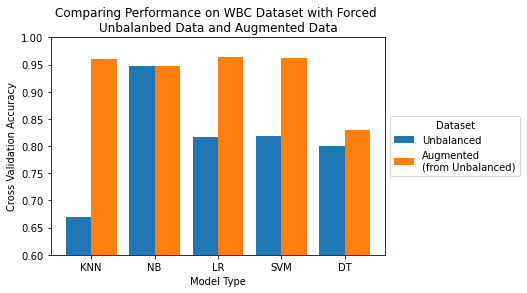

In [10]:
import matplotlib.pyplot as plt 
  
X = ['KNN','NB','LR','SVM', 'DT']

undersampled = [np.mean(underknnScores), np.mean(undernaiveBaysScores), np.mean(underlogisticRegressionScores),
        np.mean(undersvmRegressionScores), np.mean(underdecisionTreeRegressionScores)]
underAug = [np.mean(underAugmentedKnnScores), np.mean(underAugmentedNaiveBaysScores), np.mean(underAugmentedLogisticRegressionScores),
        np.mean(underAugmentedSvmRegressionScores), np.mean(underAugmentedDecisionTreeRegressionScores)]

Ygirls = [10,20,20,40]
Zboys = [20,30,25,30]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, undersampled, 0.4, label = 'Unbalanced')
plt.bar(X_axis + 0.2, underAug, 0.4, label = 'Augmented\n(from Unbalanced)')
  
plt.xticks(X_axis, X)
plt.xlabel("Model Type")
plt.ylabel("Cross Validation Accuracy")
plt.ylim(0.6,1)
plt.title("Comparing Performance on WBC Dataset with Forced \nUnbalanbed Data and Augmented Data")
plt.legend(title='Dataset',loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()